# Imports

In [ ]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# DATA PREPROCESSING

In [ ]:
data_path = r"/content/drive/MyDrive/Colab Notebooks/AI/hotel_bookings.csv"

# Load
df = pd.read_csv(data_path)

# Parse reservation status date
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], errors='coerce')
if df['reservation_status_date'].isna().any():
    df['reservation_status_date'] = df['reservation_status_date'].fillna(df['reservation_status_date'].mode()[0])
missi
# Handle missing values
df['children'] = df['children'].fillna(0)
df['country'] = df['country'].fillna('Unknown')
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)

# Fix types
df['children'] = df['children'].astype(int)
df['agent'] = df['agent'].astype(int)
df['company'] = df['company'].astype(int)

# Normalize month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['arrival_date_month'] = df['arrival_date_month'].map(month_map).astype(int)

# Drop duplicates and impossible rows
df = df.drop_duplicates()
df = df[~((df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0))]

# Outlier handling
df = df[df['adr'] >= 0]
df['adr'] = df['adr'].clip(upper=df['adr'].quantile(0.99))
for col in ['lead_time', 'stays_in_week_nights', 'stays_in_weekend_nights']:
    df[col] = df[col].clip(upper=df[col].quantile(0.99))

# Categorical encoding
country_counts = df['country'].value_counts()
rare_countries = country_counts[country_counts < 30].index
df['country'] = df['country'].replace(rare_countries, 'Other')

#le = LabelEncoder()
#df['country_encoded'] = le.fit_transform(df['country'])
#df = df.drop(columns=['country'])



cat_to_onehot = ['country','hotel', 'meal', 'market_segment', 'distribution_channel',
                 'reserved_room_type', 'assigned_room_type',
                 'deposit_type', 'customer_type', 'city']
df = pd.get_dummies(df, columns=cat_to_onehot, drop_first=True)

# Drop ID/leak columns
df = df.drop(columns=['company', 'agent', 'reservation_status'], errors='ignore')

df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,city_Delhi,city_Goa,city_Hyderabad,city_Indore,city_Jaipur,city_Kochi,city_Kolkata,city_Lucknow,city_Mumbai,city_Pune
0,0,342,2024,7,30,27,0,0,2,0,...,False,False,False,False,False,False,False,False,False,False
1,0,444,2024,4,17,28,0,0,2,0,...,False,False,False,False,False,False,False,False,True,False
2,0,7,2024,9,37,10,0,1,1,0,...,True,False,False,False,False,False,False,False,False,False
3,0,13,2024,8,33,14,0,1,1,0,...,False,False,False,False,False,False,True,False,False,False
4,0,14,2024,9,37,14,0,2,2,0,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
# Save cleaned (preprocessed) dataset
clean_path = r"/content/drive/MyDrive/Colab Notebooks/hotel_bookings_cleaned.csv"
df.to_csv(clean_path, index=False)
clean_path

'/content/drive/MyDrive/Colab Notebooks/hotel_bookings_cleaned.csv'

# **EDA(Exploratory Data Analysis)**


## Distribution of cancellations

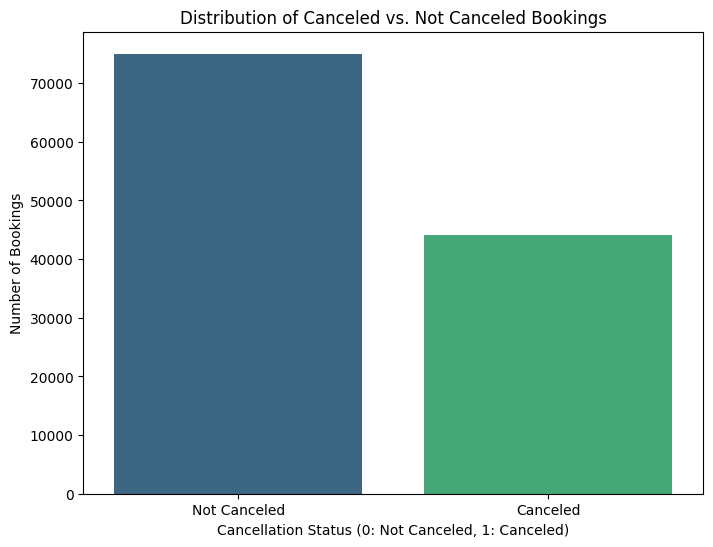

In [ ]:
cancellation_counts = df['is_canceled'].value_counts().reset_index()
cancellation_counts.columns = ['is_canceled', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(x='is_canceled', y='count', data=cancellation_counts, palette='viridis')
plt.title('Distribution of Canceled vs. Not Canceled Bookings')
plt.xlabel('Cancellation Status (0: Not Canceled, 1: Canceled)')
plt.ylabel('Number of Bookings')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()

shows imbalance in the data set will be resolved with SMOTE later

## Booking trends by month, week, city

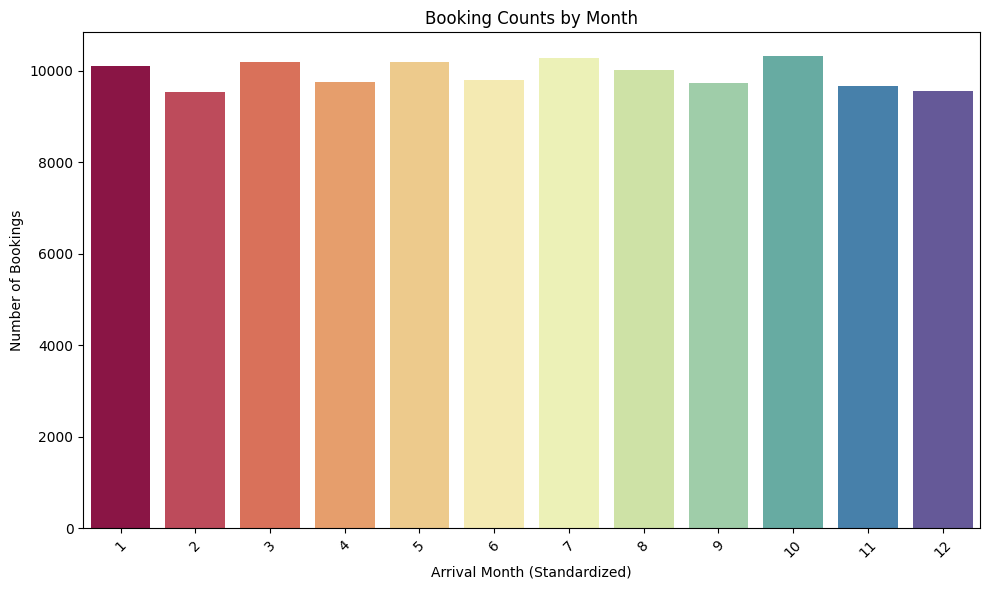

In [ ]:
#Booking Counts by Month
monthly_bookings = df.groupby('arrival_date_month').size().reset_index(name='booking_count')

plt.figure(figsize=(10, 6))
sns.barplot(x='arrival_date_month', y='booking_count', hue='arrival_date_month', data=monthly_bookings, palette='Spectral', legend=False)
plt.title('Booking Counts by Month')
plt.xlabel('Arrival Month (Standardized)')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

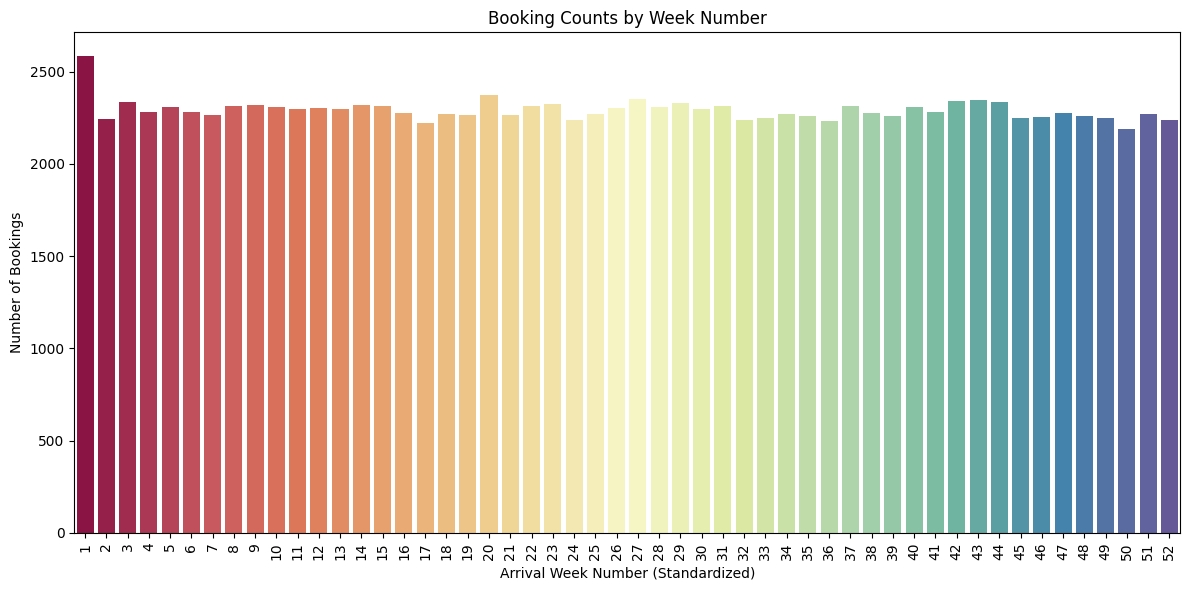

In [ ]:
# Group by arrival_date_week_number and count bookings
weekly_bookings = df.groupby('arrival_date_week_number').size().reset_index(name='booking_count')

plt.figure(figsize=(12, 6))
sns.barplot(x='arrival_date_week_number', y='booking_count', hue='arrival_date_week_number', data=weekly_bookings, palette='Spectral', legend=False)
plt.title('Booking Counts by Week Number')
plt.xlabel('Arrival Week Number (Standardized)')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

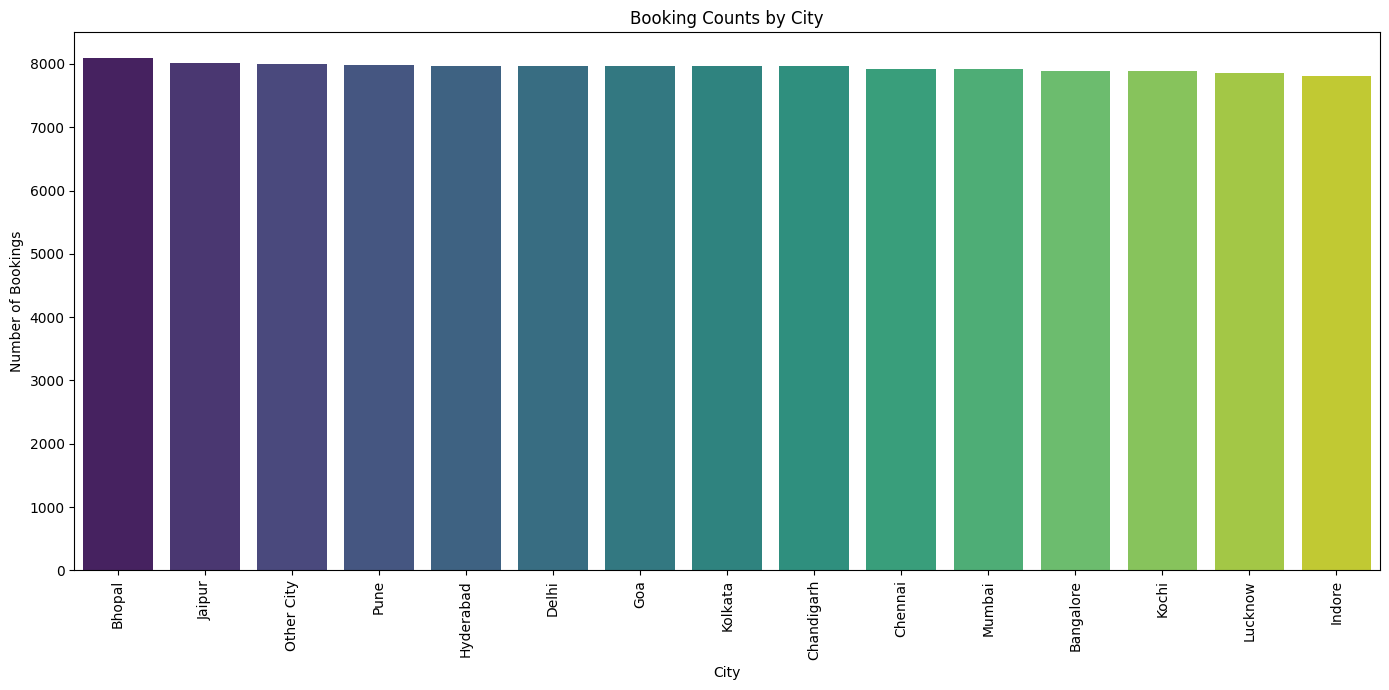

In [ ]:
city_columns = [col for col in df.columns if col.startswith('city_')]
city_booking_counts = pd.DataFrame(columns=['city', 'booking_count'])

for col in city_columns:
    city_name = col.replace('city_', '')
    count = df[col].sum()
    city_booking_counts = pd.concat([city_booking_counts, pd.DataFrame([{'city': city_name, 'booking_count': count}])], ignore_index=True)

# Calculate bookings for the 'other' category (the one implicitly dropped by drop_first=True)
total_explicit_city_bookings = city_booking_counts['booking_count'].sum()
total_bookings = len(df)
other_city_bookings = total_bookings - total_explicit_city_bookings

# Add 'Other City' if there are bookings not accounted for by the explicit one-hot encoded columns
if other_city_bookings > 0:
    city_booking_counts = pd.concat([city_booking_counts, pd.DataFrame([{'city': 'Other City', 'booking_count': other_city_bookings}])], ignore_index=True)

# Sort the cities by booking count for better visualization
city_booking_counts = city_booking_counts.sort_values(by='booking_count', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x='city', y='booking_count', hue='city', data=city_booking_counts, palette='viridis', legend=False)
plt.title('Booking Counts by City')
plt.xlabel('City')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

I observed that bookings follow clear patterns and are not random, which means these features contain useful information and should be kept for modeling.

##  Relationship between ADR and cancellations


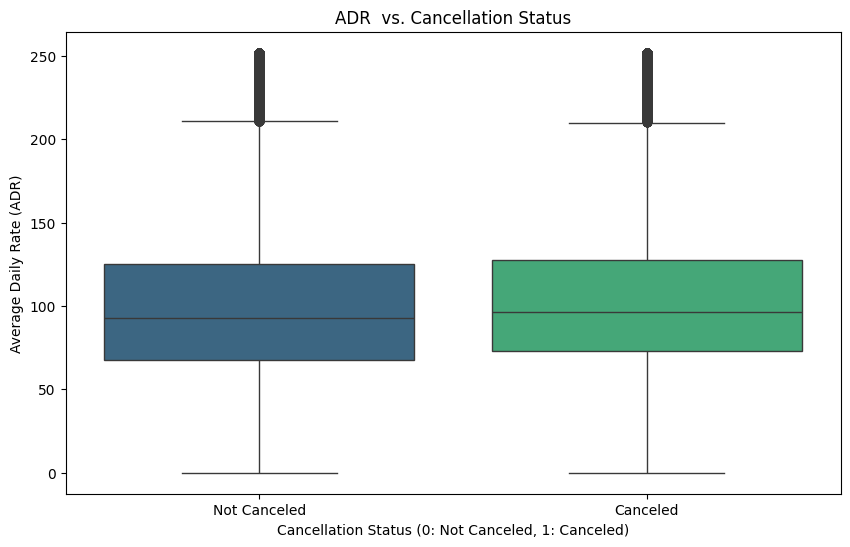

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_canceled', y='adr', data=df, palette='viridis', hue='is_canceled', legend=False)
plt.title('ADR  vs. Cancellation Status')
plt.xlabel('Cancellation Status (0: Not Canceled, 1: Canceled)')
plt.ylabel('Average Daily Rate (ADR)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()

While expensive rooms are canceled slightly more often, price isn't the only reason people cancel.

Median: People who canceled their rooms were generally paying a slightly higher price than people who actually showed up!

The Colored Box: Higher prices make people a little more nervous, so they might be more likely to cancel if they find a better deal elsewhere.

Black Seeds: these are "Outliers."

## Correlation heatmap

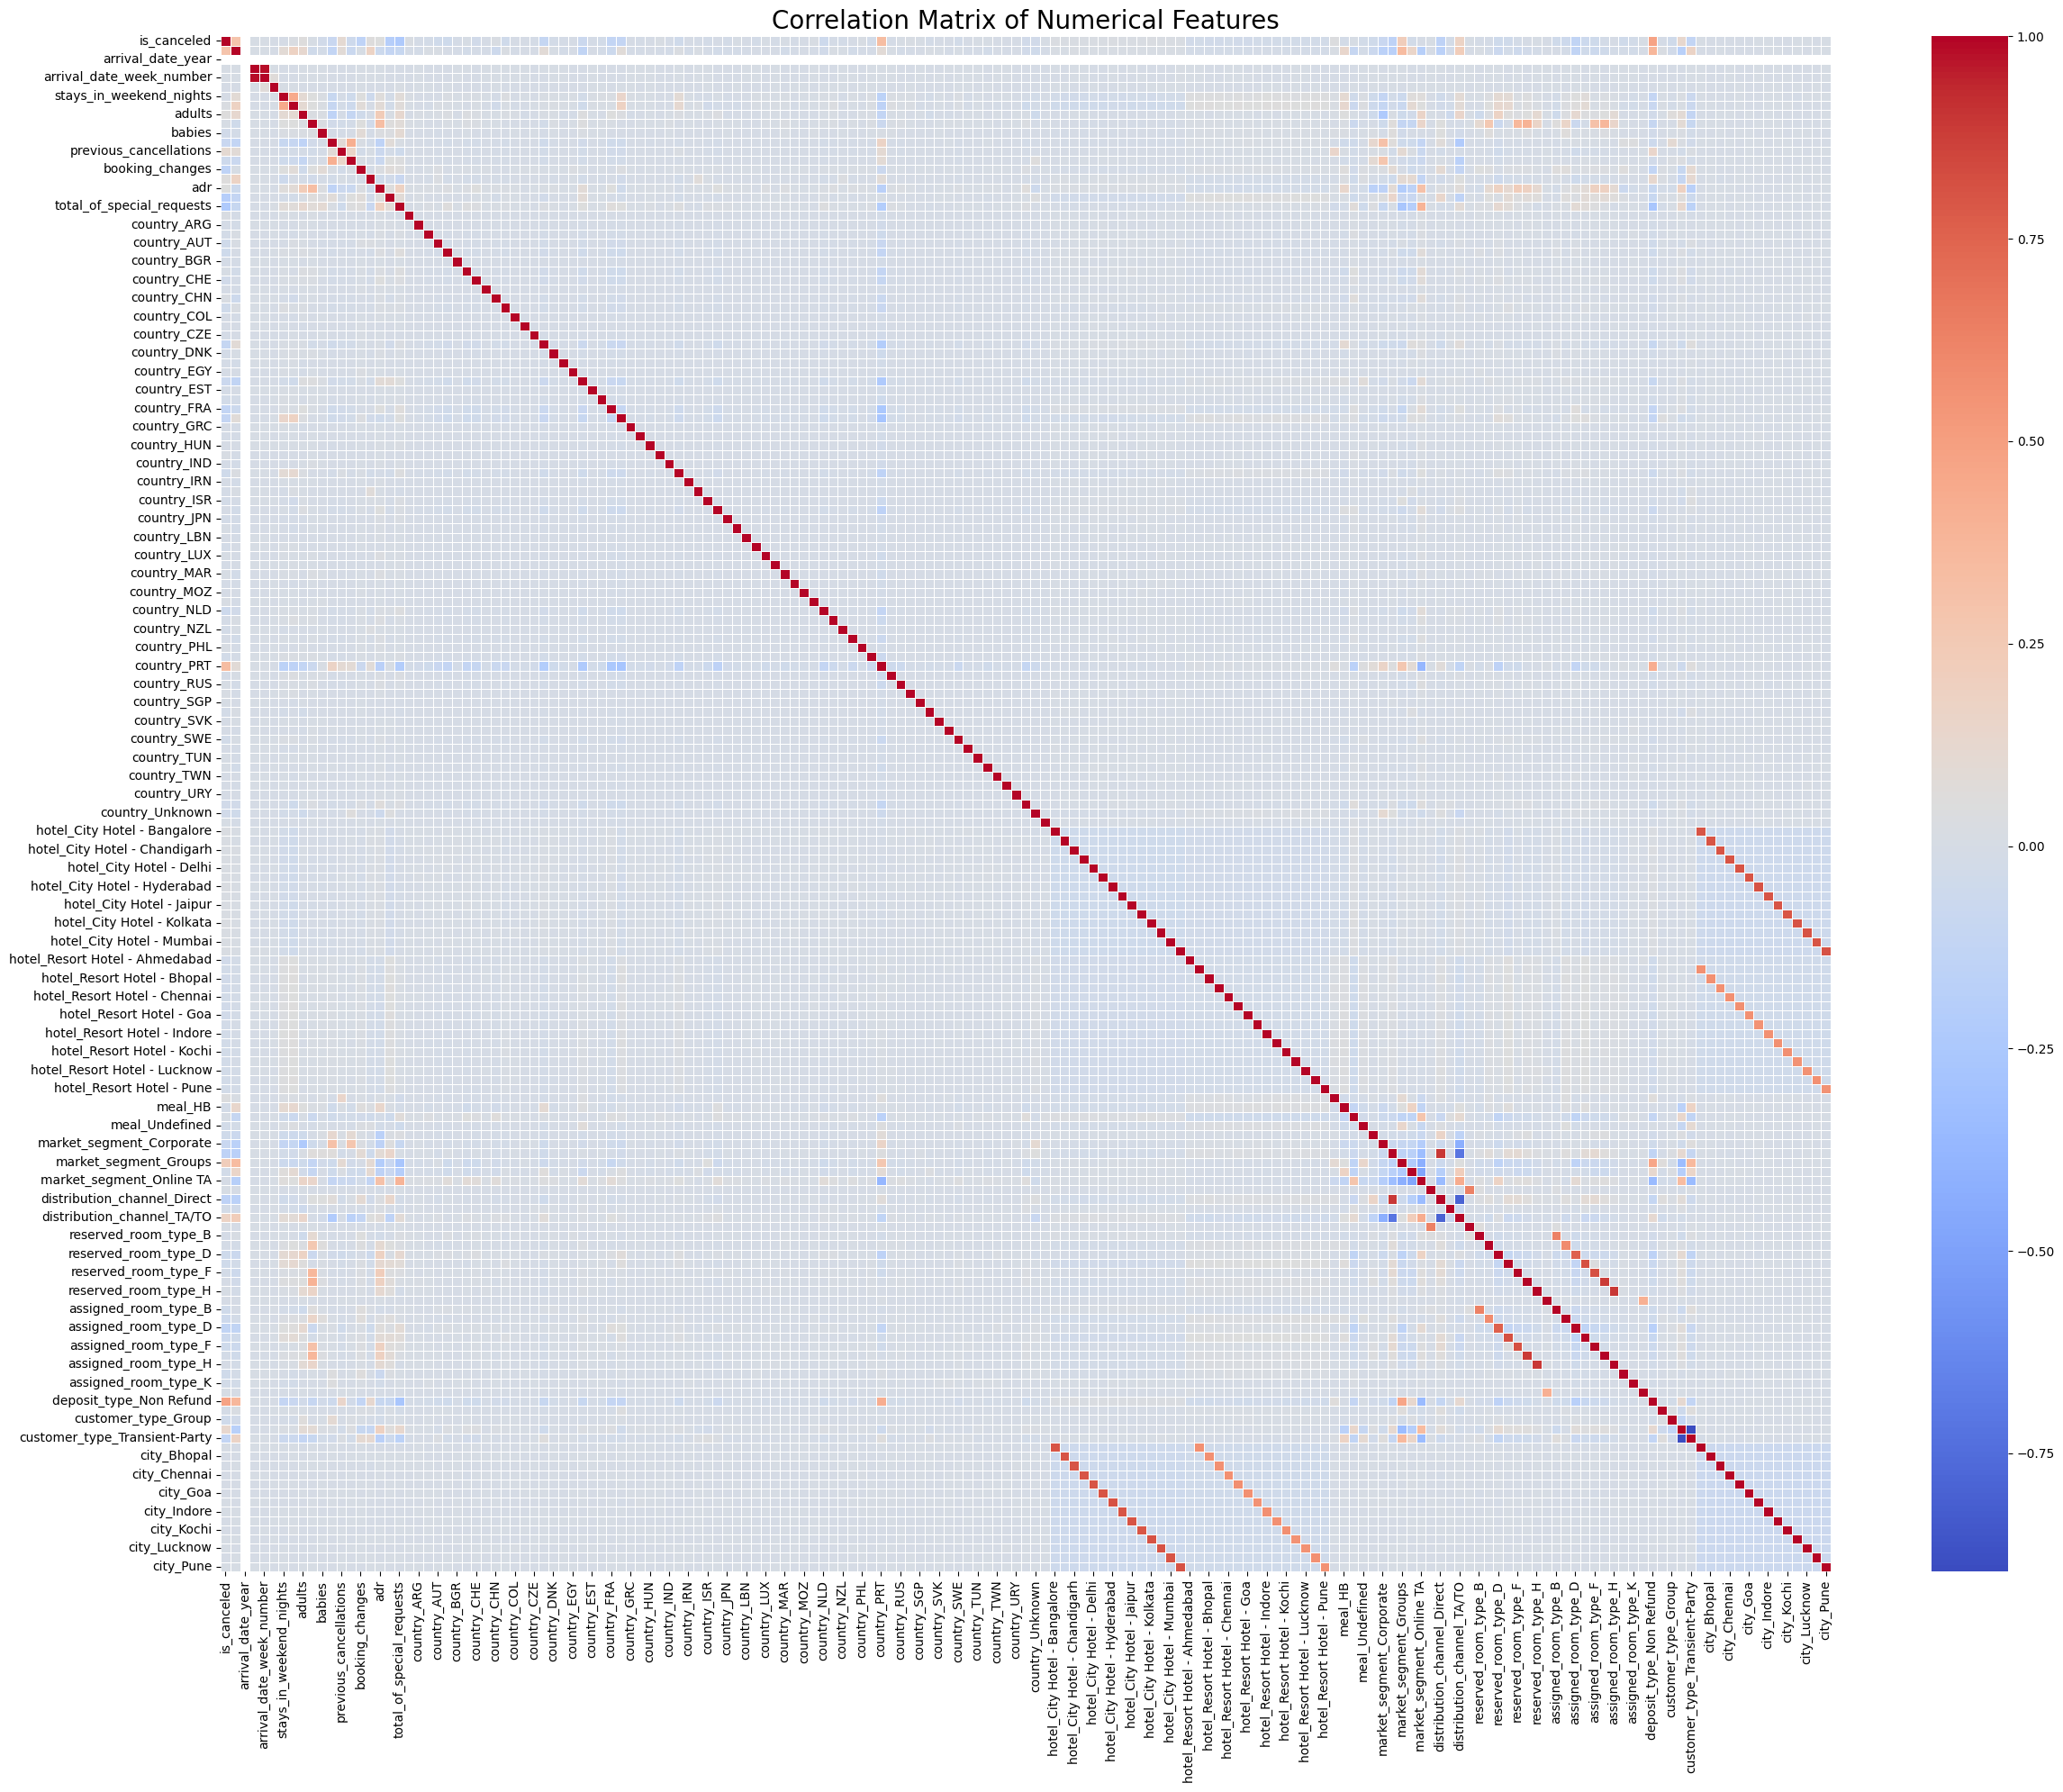

In [ ]:

all_numeric_cols = df.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

# Convert boolean columns to int if any exist, as corr() might treat them differently
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

# Recalculate all_numeric_cols after type conversion
all_numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calculate the correlation matrix
correlation_matrix = df[all_numeric_cols].corr()

# Set up the matplotlib figure
plt.figure(figsize=(25, 20)) # Increased figure size for better readability of many features

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Red things make a "Yes" (canceled) more likely.

Blue things make a "No" (staying) more likely.

White things don't really care either way

Lead Time,Deposit Type,Previous Cancellations, country_PRT -> is_canceled
Total Special Requests ,Required Car Parking Spaces > not canceled

##  Lead time analysis

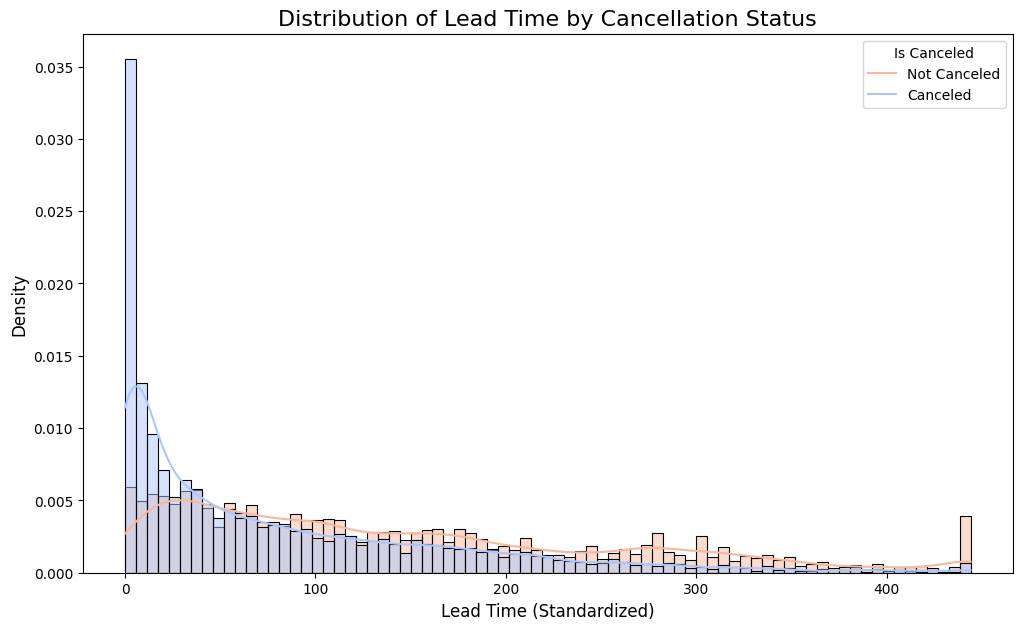

In [ ]:
plt.figure(figsize=(12, 7))
sns.histplot(data=df, x='lead_time', hue='is_canceled', kde=True, stat='density', common_norm=False, palette='coolwarm')
plt.title('Distribution of Lead Time by Cancellation Status', fontsize=16)
plt.xlabel('Lead Time (Standardized)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

 blue tower shows that re people who booked their room and showed up almost immediately (like the same day or a few days later). (no time to change your mind)

 The Blue Line drops down very fast. It shows that people who book "last minute" almost always show up.

The Orange Line stays higher for much longer. It shows that as the waiting time gets longer, the "Cancellation" group starts to take over.

## Categorical plots (hotel type, market segment, customer type)

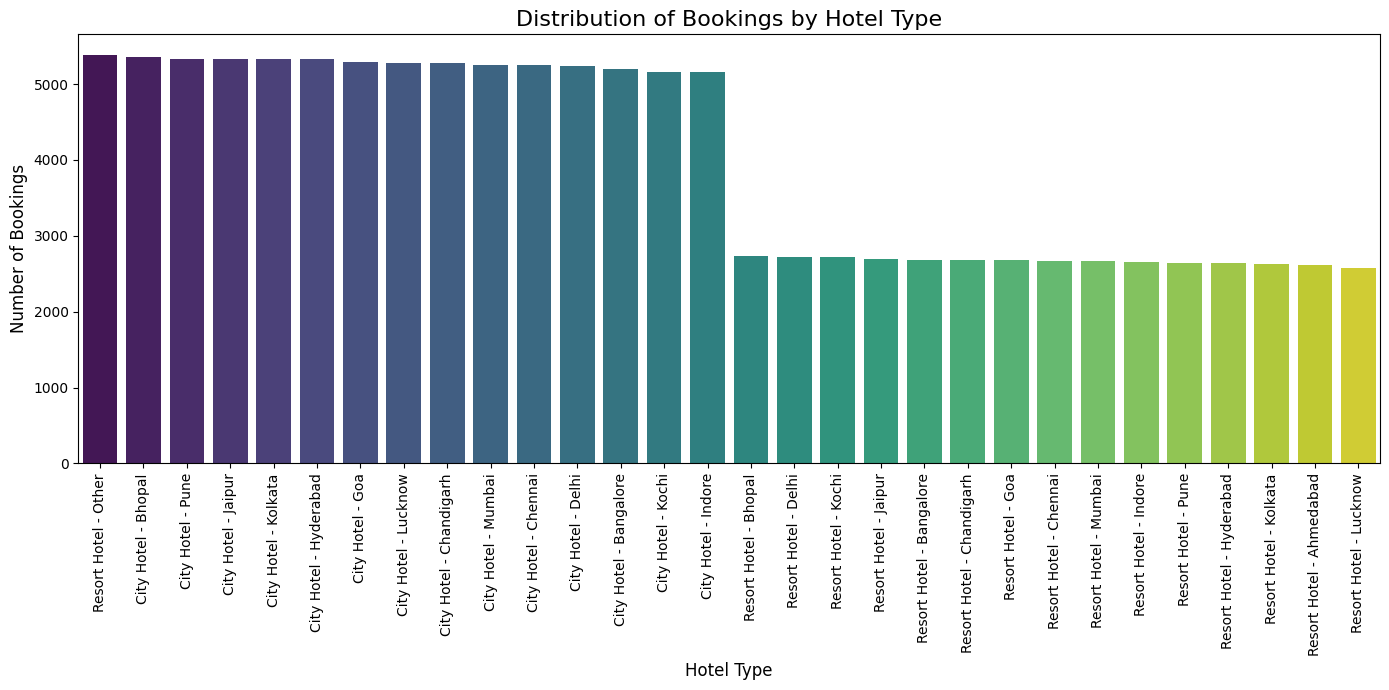

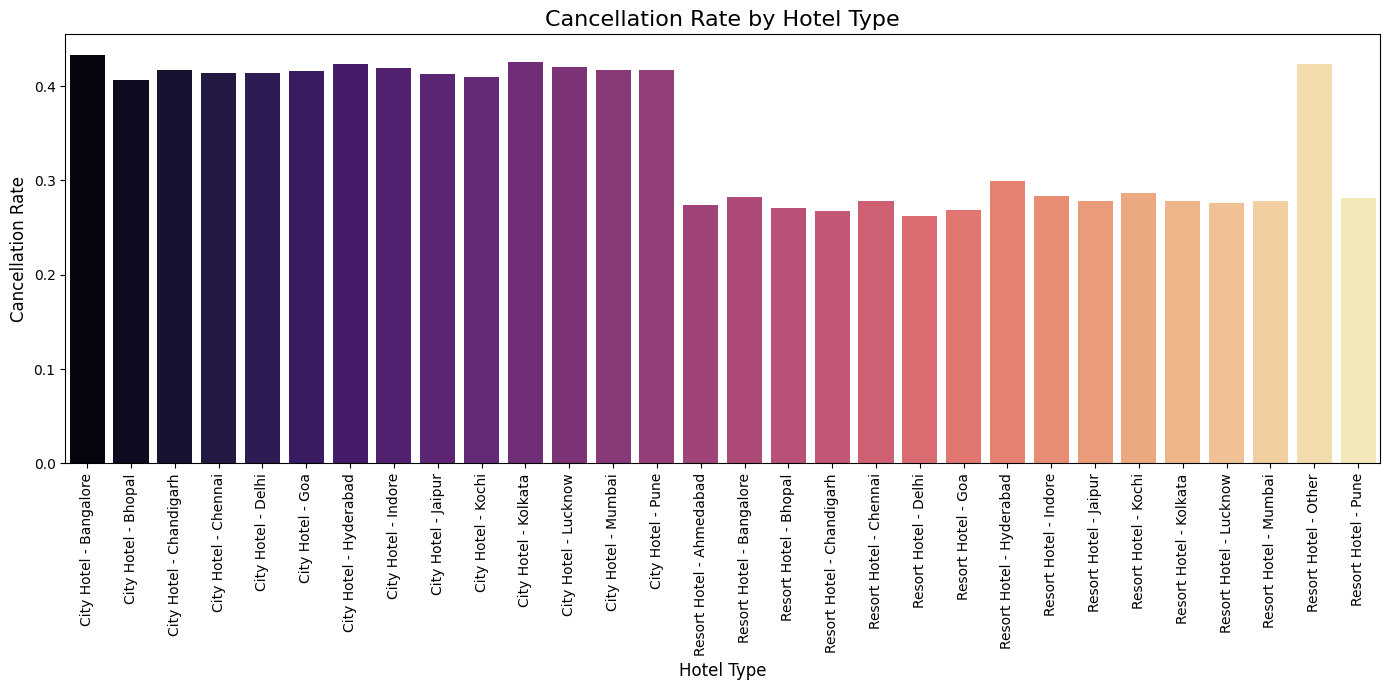

In [ ]:

# Create a temporary DataFrame to reconstruct the 'hotel' type
df_temp = df.copy()

# Identify all one-hot encoded hotel columns
hotel_ohe_cols = [col for col in df_temp.columns if col.startswith('hotel_')]

# Reconstruct the 'hotel_type' column
# Initialize with a default value for the category dropped by drop_first=True
df_temp['hotel_type'] = 'Resort Hotel - Other'

# Assign the actual hotel type based on the one-hot encoded columns
for col in hotel_ohe_cols:
    hotel_name = col.replace('hotel_', '')
    df_temp.loc[df_temp[col] == 1, 'hotel_type'] = hotel_name

# 1. Calculate booking counts for each hotel type
booking_counts = df_temp['hotel_type'].value_counts().reset_index()
booking_counts.columns = ['hotel_type', 'booking_count']

# 2. Calculate the cancellation rate for each hotel type
cancellation_data = df_temp.groupby('hotel_type')['is_canceled'].agg(['count', 'sum'])
cancellation_data.columns = ['total_bookings', 'canceled_bookings']
cancellation_data['cancellation_rate'] = cancellation_data['canceled_bookings'] / cancellation_data['total_bookings']
cancellation_data = cancellation_data.reset_index()

# 3. Create a bar chart showing the distribution of bookings by hotel type
plt.figure(figsize=(14, 7))
sns.barplot(x='hotel_type', y='booking_count', hue='hotel_type', data=booking_counts, palette='viridis', legend=False)
plt.title('Distribution of Bookings by Hotel Type', fontsize=16)
plt.xlabel('Hotel Type', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4. Create a bar chart showing the cancellation rate for each hotel type
plt.figure(figsize=(14, 7))
sns.barplot(x='hotel_type', y='cancellation_rate', hue='hotel_type', data=cancellation_data, palette='magma', legend=False)
plt.title('Cancellation Rate by Hotel Type', fontsize=16)
plt.xlabel('Hotel Type', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

All hotels get almost the same number of bookings. No single hotel gets too many or too few.
City hotels have many more cancellations than resort hotels. This means city hotels are riskier when it comes to cancellations.

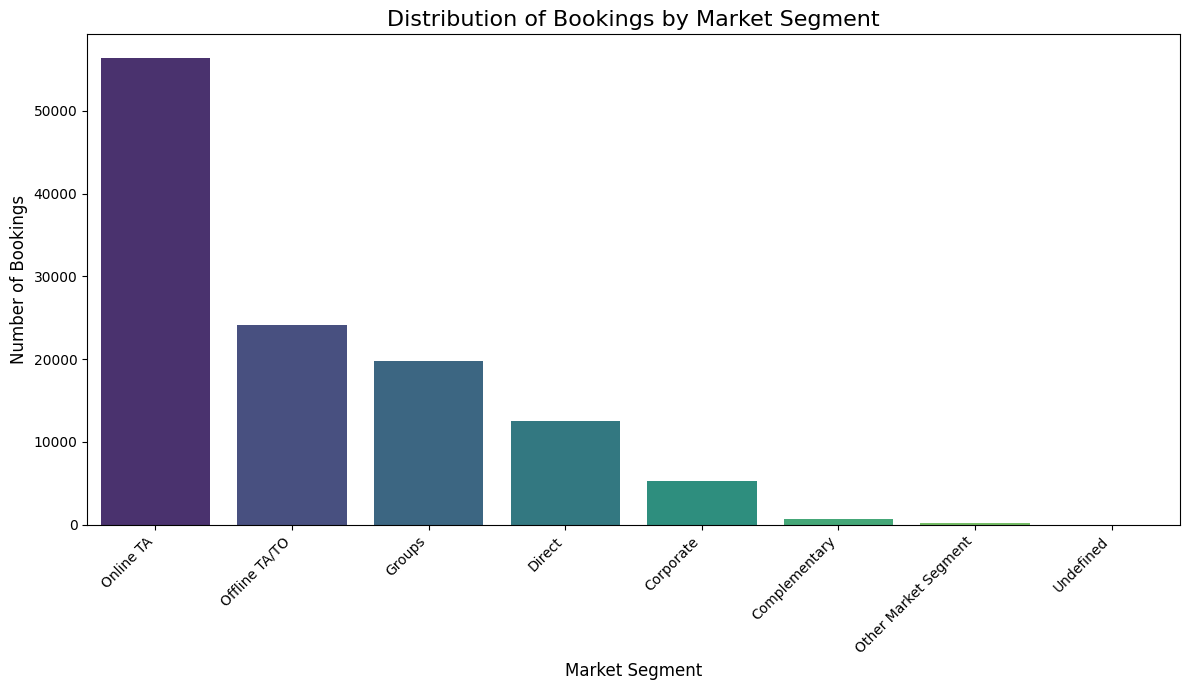

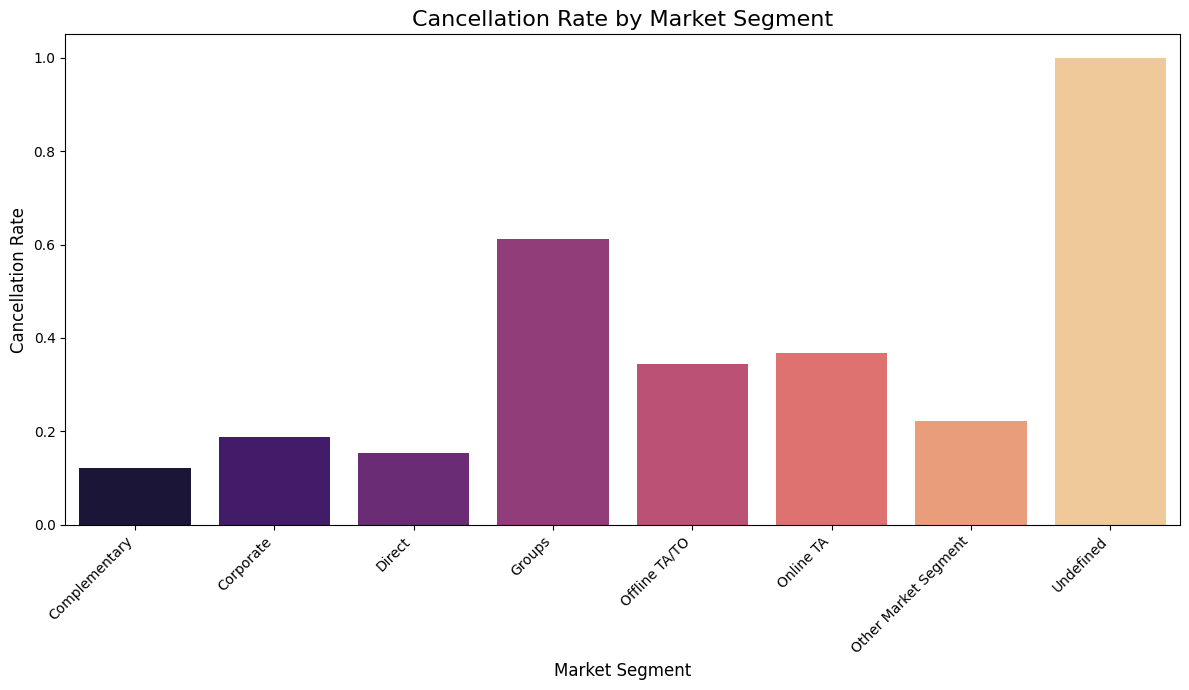

In [ ]:

# 1. Create a temporary DataFrame for this analysis
df_temp = df.copy()

# 2. Identify all columns that correspond to the one-hot encoded 'market_segment' categories
market_segment_ohe_cols = [col for col in df_temp.columns if col.startswith('market_segment_')]

# 3. Reconstruct the original 'market_segment' column
# Initialize with a default value for the category dropped by drop_first=True
# Based on the available OHE columns, the dropped one could be 'Aviation' or 'Complementary' or 'Undefined'.
# We'll use a generic 'Other Market Segment' as default.
df_temp['market_segment_type'] = 'Other Market Segment'

# Assign the actual market segment type based on the one-hot encoded columns
for col in market_segment_ohe_cols:
    segment_name = col.replace('market_segment_', '')
    df_temp.loc[df_temp[col] == 1, 'market_segment_type'] = segment_name

# 4. Calculate the total number of bookings for each unique 'market_segment'
market_segment_booking_counts = df_temp['market_segment_type'].value_counts().reset_index()
market_segment_booking_counts.columns = ['market_segment_type', 'booking_count']

# 5. Calculate the cancellation rate for each 'market_segment'
market_segment_cancellation_data = df_temp.groupby('market_segment_type')['is_canceled'].agg(['count', 'sum'])
market_segment_cancellation_data.columns = ['total_bookings', 'canceled_bookings']
market_segment_cancellation_data['cancellation_rate'] = market_segment_cancellation_data['canceled_bookings'] / market_segment_cancellation_data['total_bookings']
market_segment_cancellation_data = market_segment_cancellation_data.reset_index()

# 6. Generate a bar chart showing the distribution of bookings by 'market_segment'
plt.figure(figsize=(12, 7))
sns.barplot(x='market_segment_type', y='booking_count', hue='market_segment_type', data=market_segment_booking_counts, palette='viridis', legend=False)
plt.title('Distribution of Bookings by Market Segment', fontsize=16)
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Generate a bar chart showing the cancellation rate for each 'market_segment'
plt.figure(figsize=(12, 7))
sns.barplot(x='market_segment_type', y='cancellation_rate', hue='market_segment_type', data=market_segment_cancellation_data, palette='magma', legend=False)
plt.title('Cancellation Rate by Market Segment', fontsize=16)
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Most bookings come from online websites like travel apps. Fewer people book directly, so the hotel depends a lot on third-party websites.

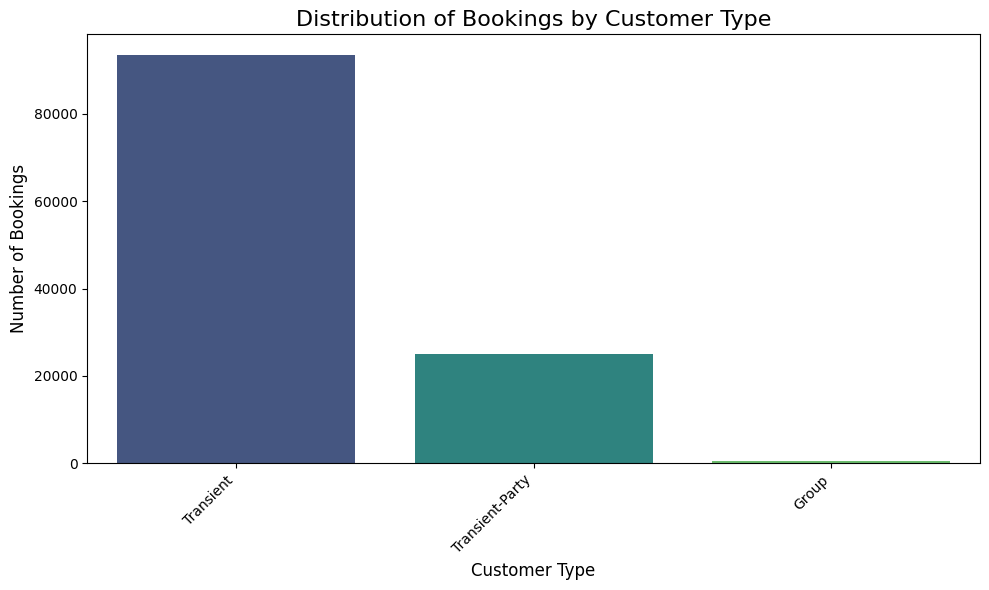

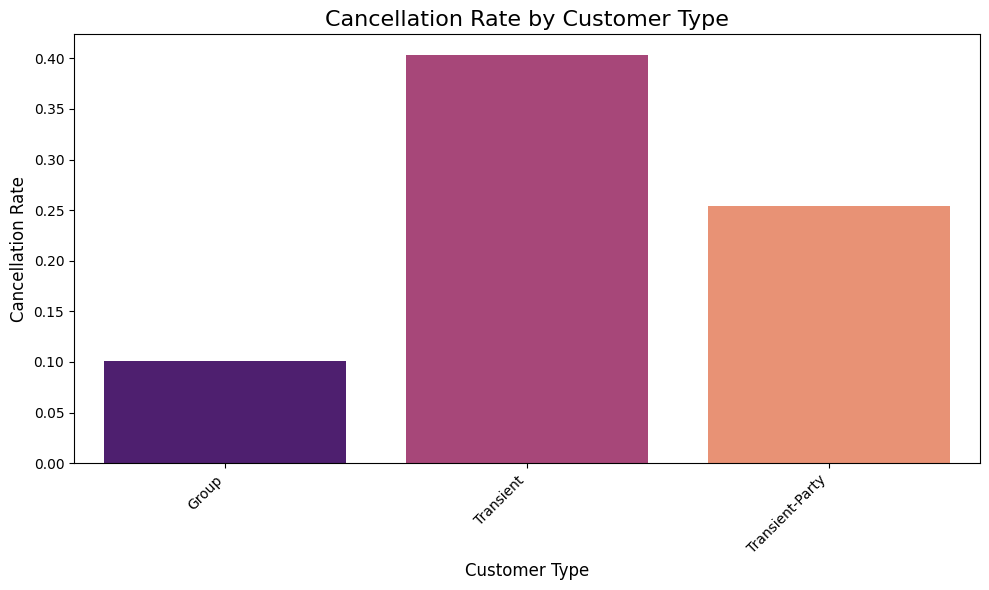

In [ ]:


# 1. Create a temporary DataFrame for this analysis
df_temp = df.copy()

# 2. Identify all columns that correspond to the one-hot encoded 'customer_type' categories
customer_type_ohe_cols = [col for col in df_temp.columns if col.startswith('customer_type_')]

# 3. Reconstruct the original 'customer_type' column
# Initialize with a default value for the category dropped by drop_first=True (likely 'Transient')
df_temp['customer_type'] = 'Transient'

# Assign the actual customer type based on the one-hot encoded columns
for col in customer_type_ohe_cols:
    customer_type_name = col.replace('customer_type_', '')
    df_temp.loc[df_temp[col] == 1, 'customer_type'] = customer_type_name

# 4. Calculate the total number of bookings for each unique 'customer_type'
customer_type_booking_counts = df_temp['customer_type'].value_counts().reset_index()
customer_type_booking_counts.columns = ['customer_type', 'booking_count']

# 5. Calculate the cancellation rate for each 'customer_type'
customer_type_cancellation_data = df_temp.groupby('customer_type')['is_canceled'].agg(['count', 'sum'])
customer_type_cancellation_data.columns = ['total_bookings', 'canceled_bookings']
customer_type_cancellation_data['cancellation_rate'] = customer_type_cancellation_data['canceled_bookings'] / customer_type_cancellation_data['total_bookings']
customer_type_cancellation_data = customer_type_cancellation_data.reset_index()

# 6. Generate a bar chart showing the distribution of bookings by 'customer_type'
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_type', y='booking_count', hue='customer_type', data=customer_type_booking_counts, palette='viridis', legend=False)
plt.title('Distribution of Bookings by Customer Type', fontsize=16)
plt.xlabel('Customer Type', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Generate a bar chart showing the cancellation rate for each 'customer_type'
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_type', y='cancellation_rate', hue='customer_type', data=customer_type_cancellation_data, palette='magma', legend=False)
plt.title('Cancellation Rate by Customer Type', fontsize=16)
plt.xlabel('Customer Type', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Most people who book hotels are single travelers or small families. Almost no big groups book, so the hotel mostly serves regular people, not large events.

In [ ]:
# =============================================
# FIXED: CHECK CURRENT STATUS
# =============================================

print("📊 CHECKING CURRENT STATUS")
print("="*50)

print("1. DATA INFO:")
print(f"   Data shape: {df.shape}")
print(f"   Memory usage: {df.memory_usage().sum() / 1024**2:.1f} MB")

print("\n2. PREPROCESSING COMPLETED:")
print("   ✓ Data loaded and cleaned")
print(f"   ✓ Missing values handled (null count: {df.isnull().sum().sum()})")
print(f"   ✓ Data types: {df.dtypes.nunique()} unique types")

# Count one-hot encoded columns
one_hot_cols = [col for col in df.columns if 'hotel_' in col or 'city_' in col or 'meal_' in col]
print(f"   ✓ Categorical features encoded: {len(one_hot_cols)} one-hot columns")

print("\n3. TARGET VARIABLE:")
target_counts = df['is_canceled'].value_counts()
print(f"   ✓ Target found: is_canceled")
print(f"   ✓ Not canceled: {target_counts[0]:,} ({target_counts[0]/len(df)*100:.1f}%)")
print(f"   ✓ Canceled: {target_counts[1]:,} ({target_counts[1]/len(df)*100:.1f}%)")
print(f"   ✓ Imbalance ratio: {target_counts[0]/target_counts[1]:.1f}:1")



📊 CHECKING CURRENT STATUS
1. DATA INFO:
   Data shape: (119193, 168)
   Memory usage: 153.7 MB

2. PREPROCESSING COMPLETED:
   ✓ Data loaded and cleaned
   ✓ Missing values handled (null count: 0)
   ✓ Data types: 3 unique types
   ✓ Categorical features encoded: 47 one-hot columns

3. TARGET VARIABLE:
   ✓ Target found: is_canceled
   ✓ Not canceled: 75,006 (62.9%)
   ✓ Canceled: 44,187 (37.1%)
   ✓ Imbalance ratio: 1.7:1


# **Balancing Data**

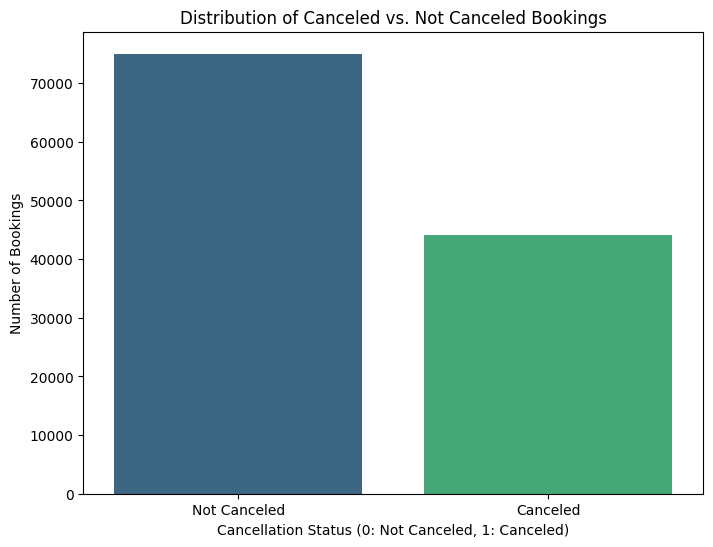

In [ ]:

#nabil
cancellation_counts = df['is_canceled'].value_counts().reset_index()
cancellation_counts.columns = ['is_canceled', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(x='is_canceled', y='count', hue='is_canceled', data=cancellation_counts, palette='viridis', legend=False)
plt.title('Distribution of Canceled vs. Not Canceled Bookings')
plt.xlabel('Cancellation Status (0: Not Canceled, 1: Canceled)')
plt.ylabel('Number of Bookings')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()

In [ ]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

print(f"Original dataset shape: X={X.shape}, y={y.shape}")
print(f"Original target distribution:\n{y.value_counts()}")

Original dataset shape: X=(119193, 167), y=(119193,)
Original target distribution:
is_canceled
0    75006
1    44187
Name: count, dtype: int64


In [ ]:
X = df.drop(['is_canceled', 'reservation_status_date'], axis=1)
y = df['is_canceled']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Resampled dataset shape: X_resampled={X_resampled.shape}, y_resampled={y_resampled.shape}")
print(f"Resampled target distribution:\n{y_resampled.value_counts()}")

Resampled dataset shape: X_resampled=(150012, 166), y_resampled=(150012,)
Resampled target distribution:
is_canceled
0    75006
1    75006
Name: count, dtype: int64


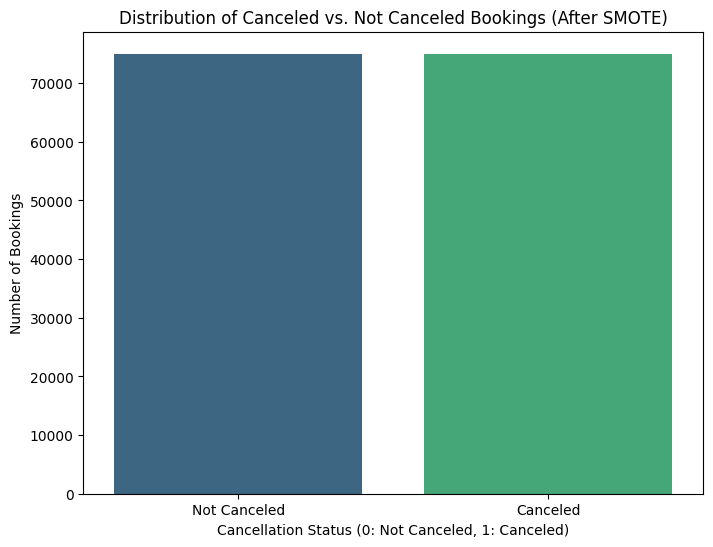

In [ ]:
# ---------------------------------
# Plot distribution AFTER SMOTE
# ---------------------------------

# Count values after resampling
balanced_counts = y_resampled.value_counts().reset_index()
balanced_counts.columns = ['is_canceled', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(
    x='is_canceled',
    y='count',
    hue='is_canceled',
    data=balanced_counts,
    palette='viridis',
    legend=False
)

plt.title('Distribution of Canceled vs. Not Canceled Bookings (After SMOTE)')
plt.xlabel('Cancellation Status (0: Not Canceled, 1: Canceled)')
plt.ylabel('Number of Bookings')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()


# **Feature Engineering**

In [ ]:
if 'total_people' not in df.columns:
    df['total_people'] = df['adults'] + df['children'] + df['babies']
if 'adr_per_person' not in df.columns:
    df['adr_per_person'] = df['adr'] / df['total_people'].replace(0, 1)
if 'total_stay' not in df.columns:
    df['total_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
if'is_family' not in df.columns:
   df['is_family'] = ((df['children'] + df['babies']) > 0).astype(int)

df[['total_stay', 'total_people', 'adr_per_person', 'is_family']].head(40)

,total_stay,total_people,adr_per_person,is_family
0,0,2,0.000000,0
1,0,2,0.000000,0
2,1,1,75.000000,0
3,1,1,75.000000,0
4,2,2,49.000000,0
5,2,2,49.000000,0
6,2,2,53.500000,0
7,2,2,51.500000,0
8,3,2,41.000000,0
9,3,2,52.750000,0


#  **GA**

STEP E: Feature Selection with Genetic Algorithm
Preparing data...
   Features: 166
   Samples: 150012
   Taking sample of 20,000 for faster computation...

Running Genetic Algorithm...
   Generation  5: Best F1 = 0.8109, Features = 86
   Generation 10: Best F1 = 0.8110, Features = 94
   Generation 15: Best F1 = 0.8110, Features = 94
   Generation 20: Best F1 = 0.8110, Features = 94

 Genetic Algorithm completed in 123.5 seconds

RESULTS:
   Best Fitness (F1 Score): 0.8110
   Original features: 166
   Selected features: 94
   Feature reduction: 43.4%

SELECTED FEATURES (94):
    1. lead_time
    2. arrival_date_month
    3. arrival_date_week_number
    4. arrival_date_day_of_month
    5. stays_in_week_nights
    6. children
    7. previous_bookings_not_canceled
    8. booking_changes
    9. days_in_waiting_list
   10. adr
   11. required_car_parking_spaces
   12. total_of_special_requests
   13. country_ARE
   14. country_AUS
   15. country_AUT
   16. country_BGR
   17. country_BRA
   

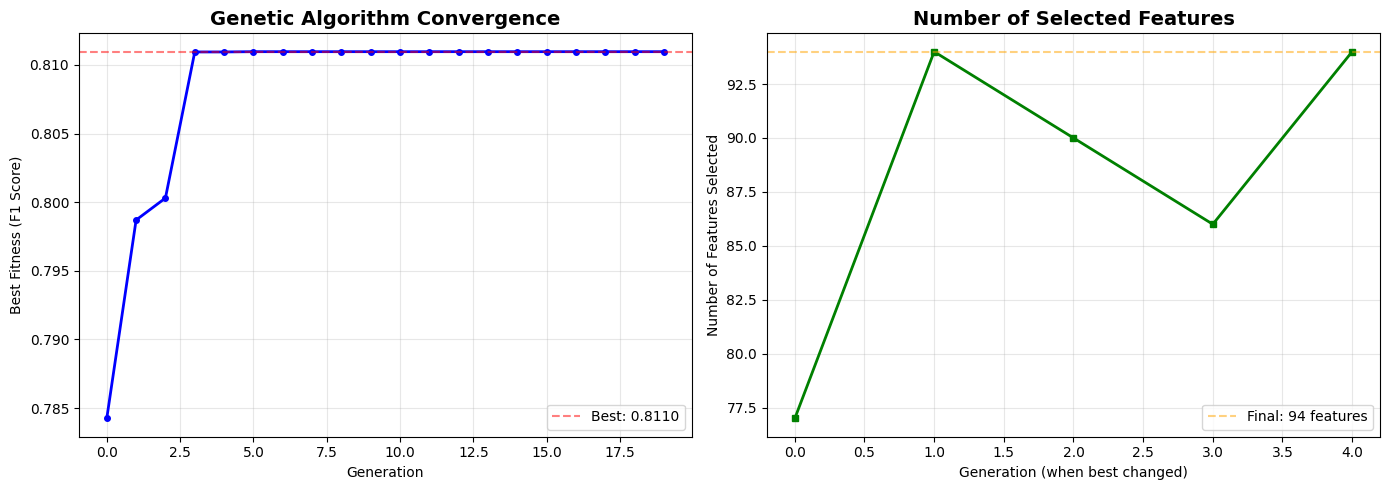


Saving selected features...
   Saved to 'selected_features_ga.csv'

Ready for modeling with 94 features


In [ ]:
# =============================================
# STEP E: FEATURE SELECTION WITH GENETIC ALGORITHM (NO CLASSES)
# =============================================

print("STEP E: Feature Selection with Genetic Algorithm")
print("="*60)

import numpy as np
import random
import time
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# =============================================
# 1. SIMPLE FUNCTIONS FOR GENETIC ALGORITHM
# =============================================

def initialize_population(n_population, n_features):
    """Create initial random population"""
    population = []
    for _ in range(n_population):
        individual = np.random.randint(0, 2, n_features)
        while np.sum(individual) < 5:  # At least 5 features
            individual = np.random.randint(0, 2, n_features)
        population.append(individual)
    return np.array(population)

def fitness_function(individual, X, y):
    """Evaluate fitness of a feature subset"""
    selected_indices = np.where(individual == 1)[0]

    if len(selected_indices) < 5:
        return 0

    X_selected = X[:, selected_indices]

    model = DecisionTreeClassifier(max_depth=10, min_samples_split=20,
                                   min_samples_leaf=10, random_state=42)

    try:
        scores = cross_val_score(model, X_selected, y, cv=3, scoring='f1', n_jobs=-1, error_score=0)
        fitness = np.mean(scores)
        penalty = 0.01 * (len(selected_indices) / len(individual))
        return max(0, fitness - penalty)
    except:
        return 0

def tournament_selection(population, fitness_scores):
    """Select individuals using tournament selection"""
    selected = []
    for _ in range(len(population)):
        indices = np.random.choice(len(population), 3, replace=False)
        winner_idx = indices[np.argmax(fitness_scores[indices])]
        selected.append(population[winner_idx].copy())
    return np.array(selected)

def crossover(parent1, parent2, crossover_rate):
    """Single-point crossover"""
    if random.random() < crossover_rate:
        point = random.randint(1, len(parent1) - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return child1, child2
    return parent1.copy(), parent2.copy()

def mutation(individual, mutation_rate):
    """Random mutation"""
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]

    if np.sum(individual) < 5:
        zero_indices = np.where(individual == 0)[0]
        if len(zero_indices) > 0:
            additional = np.random.choice(zero_indices, size=min(5, len(zero_indices)), replace=False)
            individual[additional] = 1

    return individual

# =============================================
# 2. PREPARE DATA
# =============================================

print("Preparing data...")

# Convert to numpy for faster computation
X_np = X_resampled.values
y_np = y_resampled.values
feature_names = X_resampled.columns.tolist()

print(f"   Features: {X_np.shape[1]}")
print(f"   Samples: {X_np.shape[0]}")

# Take a sample for faster computation
if X_np.shape[0] > 20000:
    print("   Taking sample of 20,000 for faster computation...")
    sample_idx = np.random.choice(X_np.shape[0], 20000, replace=False)
    X_sample = X_np[sample_idx]
    y_sample = y_np[sample_idx]
else:
    X_sample = X_np
    y_sample = y_np

# =============================================
# 3. RUN GENETIC ALGORITHM
# =============================================

print("\nRunning Genetic Algorithm...")

# Parameters
n_population = 15
n_generations = 20
mutation_rate = 0.1
crossover_rate = 0.7
n_features = X_sample.shape[1]

# Initialize
population = initialize_population(n_population, n_features)
best_individual = None
best_fitness = 0
fitness_history = []
selected_counts_history = []

start_time = time.time()

for generation in range(n_generations):
    # Evaluate fitness
    fitness_scores = []
    for individual in population:
        score = fitness_function(individual, X_sample, y_sample)
        fitness_scores.append(score)

    fitness_scores = np.array(fitness_scores)

    # Update best
    best_idx = np.argmax(fitness_scores)
    if fitness_scores[best_idx] > best_fitness:
        best_fitness = fitness_scores[best_idx]
        best_individual = population[best_idx].copy()
        selected_counts_history.append(np.sum(best_individual))

    fitness_history.append(best_fitness)

    # Selection
    selected_population = tournament_selection(population, fitness_scores)

    # Crossover and Mutation
    new_population = []
    for i in range(0, len(selected_population), 2):
        if i + 1 < len(selected_population):
            child1, child2 = crossover(selected_population[i], selected_population[i+1], crossover_rate)
            new_population.append(mutation(child1, mutation_rate))
            new_population.append(mutation(child2, mutation_rate))
        else:
            new_population.append(selected_population[i])

    population = np.array(new_population[:n_population])

    # Progress update
    if (generation + 1) % 5 == 0:
        n_selected = np.sum(best_individual) if best_individual is not None else 0
        print(f"   Generation {generation+1:2d}: "
              f"Best F1 = {best_fitness:.4f}, "
              f"Features = {n_selected}")

elapsed_time = time.time() - start_time
print(f"\n Genetic Algorithm completed in {elapsed_time:.1f} seconds")

# =============================================
# 4. GET SELECTED FEATURES
# =============================================

selected_indices = np.where(best_individual == 1)[0]
selected_features = [feature_names[i] for i in selected_indices]

print(f"\nRESULTS:")
print(f"   Best Fitness (F1 Score): {best_fitness:.4f}")
print(f"   Original features: {n_features}")
print(f"   Selected features: {len(selected_features)}")
print(f"   Feature reduction: {((n_features - len(selected_features)) / n_features * 100):.1f}%")

print(f"\nSELECTED FEATURES ({len(selected_features)}):")
for i, feature in enumerate(selected_features[:20]):  # Show first 20
    print(f"   {i+1:2d}. {feature}")

if len(selected_features) > 20:
    print(f"   ... and {len(selected_features) - 20} more")

# =============================================
# 5. VISUALIZE RESULTS
# =============================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Fitness progression
ax1.plot(fitness_history, linewidth=2, marker='o', markersize=4, color='blue')
ax1.set_title('Genetic Algorithm Convergence', fontsize=14, fontweight='bold')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Best Fitness (F1 Score)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=best_fitness, color='r', linestyle='--', alpha=0.5,
           label=f'Best: {best_fitness:.4f}')
ax1.legend()

# Feature count progression
if selected_counts_history:
    ax2.plot(range(len(selected_counts_history)), selected_counts_history,
            linewidth=2, marker='s', markersize=4, color='green')
    ax2.set_title('Number of Selected Features', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Generation (when best changed)')
    ax2.set_ylabel('Number of Features Selected')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=len(selected_features), color='orange', linestyle='--', alpha=0.5,
               label=f'Final: {len(selected_features)} features')
    ax2.legend()

plt.tight_layout()
plt.show()

# =============================================
# 6. SAVE AND PREPARE FOR MODELING
# =============================================

print(f"\nSaving selected features...")
selected_df = pd.DataFrame({
    'feature': selected_features,
    'selected': True
})
selected_df.to_csv('selected_features_ga.csv', index=False)
print("   Saved to 'selected_features_ga.csv'")

# Create datasets with selected features
X_selected = X_resampled[selected_features]
print(f"\nReady for modeling with {X_selected.shape[1]} features")



# **Model Building**


In [ ]:
# =============================================
# STEP F: MODEL BUILDING WITH SELECTED FEATURES
# =============================================

print(" STEP F: Building Machine Learning Models")
print("="*60)

print("Using Genetic Algorithm selected features:")
print(f"   Original features: {n_features}")
print(f"   Selected features: {len(selected_features)}")
print(f"   Feature reduction: {((n_features - len(selected_features)) / n_features * 100):.1f}%")
print(f"   Best Fitness (F1 Score): {best_fitness:.4f}")

# =============================================
# 1. PREPARE DATA WITH SELECTED FEATURES
# =============================================

print("\n 1. Preparing data with selected features...")

# Use the selected features from GA
X_selected = X_resampled[selected_features]
print(f"   X_selected shape: {X_selected.shape}")

# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

print(f"\n   Data split:")
print(f"   • Training set: {X_train.shape[0]:,} samples")
print(f"   • Test set: {X_test.shape[0]:,} samples")
print(f"   • Features: {X_train.shape[1]}")
print(f"   • Training balance: {y_train.value_counts().to_dict()}")
print(f"   • Test balance: {y_test.value_counts().to_dict()}")

# =============================================
# 2. MODEL 1: DECISION TREE
# =============================================

print("\n" + "="*50)
print(" MODEL 1: Decision Tree Classifier")
print("="*50)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

# Train Decision Tree
start_time = time.time()
dt_model = DecisionTreeClassifier(
    max_depth=18,
    min_samples_split=16,
    min_samples_leaf=18,
    random_state=42
)
dt_model.fit(X_train, y_train)
dt_train_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_dt = dt_model.predict(X_test)
dt_predict_time = time.time() - start_time

# Calculate metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_cm = confusion_matrix(y_test, y_pred_dt)

print(f"   Training time: {dt_train_time:.2f} seconds")
print(f"   Prediction time: {dt_predict_time:.2f} seconds")
print(f"\n    Performance Metrics:")
print(f"   • Accuracy:  {dt_accuracy:.4f}")
print(f"   • Precision: {dt_precision:.4f}")
print(f"   • Recall:    {dt_recall:.4f}")
print(f"   • F1 Score:  {dt_f1:.4f}")

print(f"\nConfusion Matrix:")
print("╔══════════════════════════════════╗")
print("║           PREDICTED              ║")
print("╠══════════════════════════════════╣")
print("║          Not Canceled  Canceled  ║")
print("╠══════════════════════════════════╣")
print(f"║ Not       {dt_cm[0][0]:6}        {dt_cm[0][1]:6}   ║")
print("║ Canceled                         ║")
print("╠══════════════════════════════════╣")
print(f"║ Canceled  {dt_cm[1][0]:6}        {dt_cm[1][1]:6}   ║")
print("╚══════════════════════════════════╝")
# =============================================
# 3. MODEL 2: K-NEAREST NEIGHBORS (KNN)
# =============================================

print("\n" + "="*50)
print(" MODEL 2: K-Nearest Neighbors (KNN)")
print("="*50)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Scale data for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN
start_time = time.time()
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)
knn_model.fit(X_train_scaled, y_train)
knn_train_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_knn = knn_model.predict(X_test_scaled)
knn_predict_time = time.time() - start_time

# Calculate metrics
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)
knn_cm = confusion_matrix(y_test, y_pred_knn)

print(f"   Training time: {knn_train_time:.2f} seconds")
print(f"   Prediction time: {knn_predict_time:.2f} seconds")
print(f"\n    Performance Metrics:")
print(f"   • Accuracy:  {knn_accuracy:.4f}")
print(f"   • Precision: {knn_precision:.4f}")
print(f"   • Recall:    {knn_recall:.4f}")
print(f"   • F1 Score:  {knn_f1:.4f}")

print(f"\nConfusion Matrix:")
print("╔══════════════════════════════════╗")
print("║           PREDICTED              ║")
print("╠══════════════════════════════════╣")
print("║          Not Canceled  Canceled  ║")
print("╠══════════════════════════════════╣")
print(f"║ Not       {knn_cm[0][0]:6}        {knn_cm[0][1]:6}   ║")
print("║ Canceled                         ║")
print("╠══════════════════════════════════╣")
print(f"║ Canceled  {knn_cm[1][0]:6}        {knn_cm[1][1]:6}   ║")
print("╚══════════════════════════════════╝")


#nabil
# =============================================
# 4. MODEL 3: NEURAL NETWORK (MLP)
# =============================================

print("\n" + "="*50)
print("MODEL 3: Neural Network (MLP Classifier)")
print("="*50)

from sklearn.neural_network import MLPClassifier

# Train Neural Network
start_time = time.time()
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='logistic',
    solver='adam',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
mlp_model.fit(X_train_scaled, y_train)
mlp_train_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_mlp = mlp_model.predict(X_test_scaled)
mlp_predict_time = time.time() - start_time

# Calculate metrics
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
mlp_precision = precision_score(y_test, y_pred_mlp)
mlp_recall = recall_score(y_test, y_pred_mlp)
mlp_f1 = f1_score(y_test, y_pred_mlp)
mlp_cm = confusion_matrix(y_test, y_pred_mlp)

print(f"   Training time: {mlp_train_time:.2f} seconds")
print(f"   Prediction time: {mlp_predict_time:.2f} seconds")
print(f"   Final loss: {mlp_model.loss_:.4f}")
print(f"   Iterations: {mlp_model.n_iter_}")
print(f"\n   Performance Metrics:")
print(f"   • Accuracy:  {mlp_accuracy:.4f}")
print(f"   • Precision: {mlp_precision:.4f}")
print(f"   • Recall:    {mlp_recall:.4f}")
print(f"   • F1 Score:  {mlp_f1:.4f}")

print(f"\nConfusion Matrix:")
print("╔══════════════════════════════════╗")
print("║           PREDICTED              ║")
print("╠══════════════════════════════════╣")
print("║          Not Canceled  Canceled  ║")
print("╠══════════════════════════════════╣")
print(f"║ Not       {mlp_cm[0][0]:6}        {mlp_cm[0][1]:6}   ║")
print("║ Canceled                         ║")
print("╠══════════════════════════════════╣")
print(f"║ Canceled  {mlp_cm[1][0]:6}        {mlp_cm[1][1]:6}   ║")
print("╚══════════════════════════════════╝")


 STEP F: Building Machine Learning Models
Using Genetic Algorithm selected features:
   Original features: 166
   Selected features: 94
   Feature reduction: 43.4%
   Best Fitness (F1 Score): 0.8110

 1. Preparing data with selected features...
   X_selected shape: (150012, 94)

   Data split:
   • Training set: 120,009 samples
   • Test set: 30,003 samples
   • Features: 94
   • Training balance: {1: 60005, 0: 60004}
   • Test balance: {0: 15002, 1: 15001}

 MODEL 1: Decision Tree Classifier
   Training time: 1.78 seconds
   Prediction time: 0.02 seconds

    Performance Metrics:
   • Accuracy:  0.8467
   • Precision: 0.8541
   • Recall:    0.8363
   • F1 Score:  0.8451

Confusion Matrix:
╔══════════════════════════════════╗
║           PREDICTED              ║
╠══════════════════════════════════╣
║          Not Canceled  Canceled  ║
╠══════════════════════════════════╣
║ Not        12858          2144   ║
║ Canceled                         ║
╠══════════════════════════════════╣
║ Can

# Evaluation

 STEP G: Clean Model Performance Comparison

 PERFORMANCE METRICS COMPARISON:
              Model Accuracy Precision Recall F1 Score Train Time (s) Pred Time (s)
      Decision Tree   0.8467    0.8541 0.8363   0.8451            1.8           0.0
K-Nearest Neighbors   0.8178    0.8214 0.8121   0.8167            0.1          41.4
     Neural Network   0.8572    0.8826 0.8239   0.8523           73.5           0.2

 VISUALIZATION 1: Main Performance Metrics


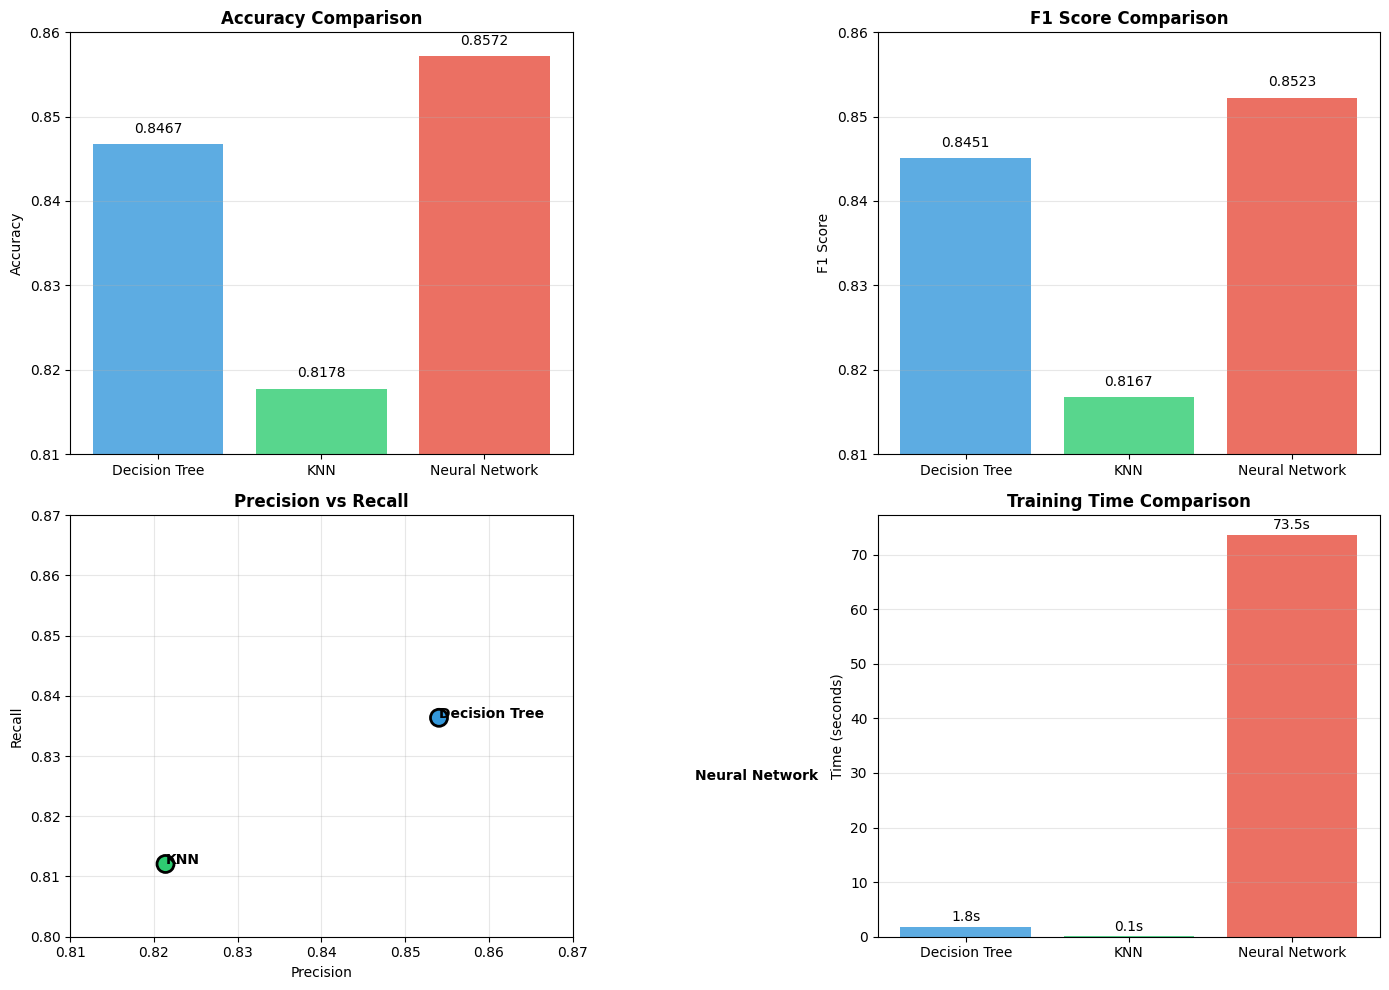


 VISUALIZATION 2: Confusion Matrices


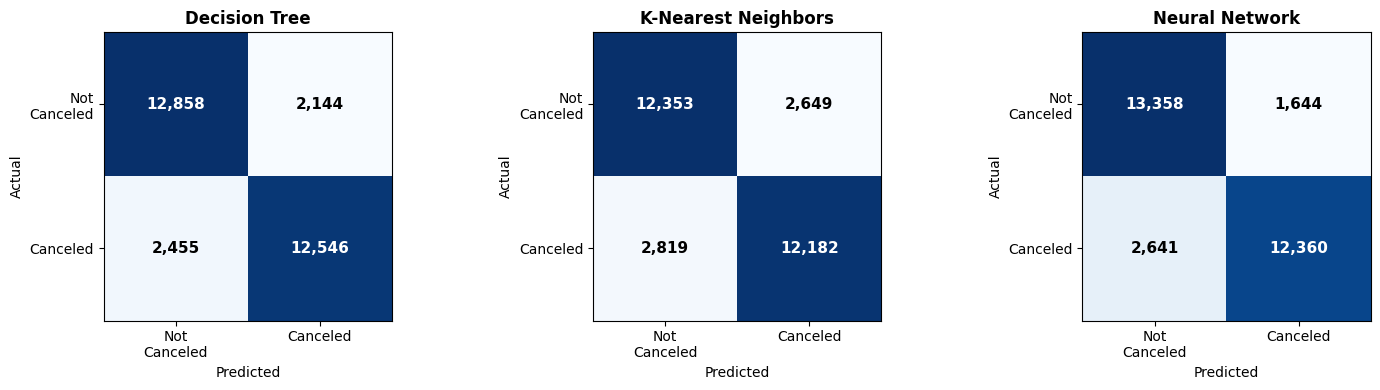


 VISUALIZATION 3: Top 10 Most Important Features


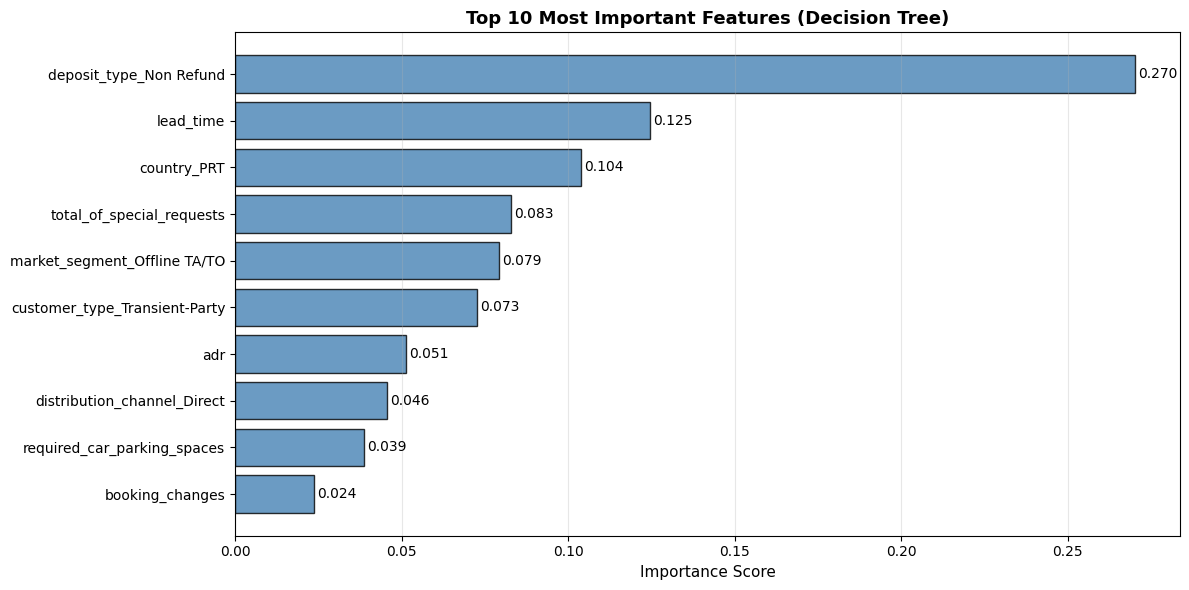


 BEST MODEL SELECTION

Based on F1 Score (balanced metric):
  BEST MODEL: Neural Network

 Performance:
   • F1 Score:    0.8523
   • Accuracy:    0.8572
   • Precision:   0.8826
   • Recall:      0.8239
   • Train Time:  73.5s

 Recommendation: Use Neural Network for hotel booking cancellation predictions
   It provides the best balance between precision and recall.

 PROJECT COMPLETION SUMMARY

 Final Results:
• Best Model: Neural Network
• Best F1 Score: 0.8523
  Feature reduction: 43.4%
• Most important feature: deposit_type_Non Refund


In [ ]:
# =============================================
# STEP G: CLEAN PERFORMANCE VISUALIZATIONS
# =============================================

print(" STEP G: Clean Model Performance Comparison")
print("="*60)

# =============================================
# 1. CLEAN METRICS COMPARISON
# =============================================

print("\n PERFORMANCE METRICS COMPARISON:")

# Create a clean metrics table
metrics_data = {
    'Model': ['Decision Tree', 'K-Nearest Neighbors', 'Neural Network'],
    'Accuracy': [f"{dt_accuracy:.4f}", f"{knn_accuracy:.4f}", f"{mlp_accuracy:.4f}"],
    'Precision': [f"{dt_precision:.4f}", f"{knn_precision:.4f}", f"{mlp_precision:.4f}"],
    'Recall': [f"{dt_recall:.4f}", f"{knn_recall:.4f}", f"{mlp_recall:.4f}"],
    'F1 Score': [f"{dt_f1:.4f}", f"{knn_f1:.4f}", f"{mlp_f1:.4f}"],
    'Train Time (s)': [f"{dt_train_time:.1f}", f"{knn_train_time:.1f}", f"{mlp_train_time:.1f}"],
    'Pred Time (s)': [f"{dt_predict_time:.1f}", f"{knn_predict_time:.1f}", f"{mlp_predict_time:.1f}"]
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string(index=False))

# =============================================
# 2. CLEAN VISUALIZATION 1: MAIN METRICS
# =============================================

print("\n VISUALIZATION 1: Main Performance Metrics")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
models = ['Decision Tree', 'KNN', 'Neural Network']
accuracies = [dt_accuracy, knn_accuracy, mlp_accuracy]
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars1 = axes[0, 0].bar(models, accuracies, color=colors, alpha=0.8)
axes[0, 0].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0.81, 0.86])
axes[0, 0].grid(axis='y', alpha=0.3)
for bar, acc in zip(bars1, accuracies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

# F1 Score
f1_scores = [dt_f1, knn_f1, mlp_f1]
bars2 = axes[0, 1].bar(models, f1_scores, color=colors, alpha=0.8)
axes[0, 1].set_title('F1 Score Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_ylim([0.81, 0.86])
axes[0, 1].grid(axis='y', alpha=0.3)
for bar, f1 in zip(bars2, f1_scores):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{f1:.4f}', ha='center', va='bottom', fontsize=10)

# Precision-Recall Trade-off
axes[1, 0].scatter([dt_precision, knn_precision, mlp_precision],
                   [dt_recall, knn_recall, mlp_recall],
                   s=150, color=colors, edgecolors='black', linewidth=2)

# Add model labels with slight offset
for i, model in enumerate(models):
    x_offset = 0.002  # Small horizontal offset for labels
    y_offset = 0.002  # Small vertical offset for labels
    axes[1, 0].text(dt_precision if i==0 else knn_precision if i==1 else mlp_precision + x_offset,
                   dt_recall if i==0 else knn_recall if i==1 else mlp_recall + y_offset,
                   model, fontsize=10, fontweight='bold')

axes[1, 0].set_title('Precision vs Recall', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_ylabel('Recall')

axes[1, 0].set_xlim([0.81, 0.87])
axes[1, 0].set_ylim([0.8, 0.87])

axes[1, 0].grid(True, alpha=0.3)

# Training Time Comparison
train_times = [dt_train_time, knn_train_time, mlp_train_time]
bars3 = axes[1, 1].bar(models, train_times, color=colors, alpha=0.8)
axes[1, 1].set_title('Training Time Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Time (seconds)')
axes[1, 1].grid(axis='y', alpha=0.3)
for bar, time_val in zip(bars3, train_times):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   f'{time_val:.1f}s', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# =============================================
# 3. CLEAN VISUALIZATION 2: CONFUSION MATRICES
# =============================================

print("\n VISUALIZATION 2: Confusion Matrices")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

confusion_matrices = [
    ('Decision Tree', dt_cm),
    ('K-Nearest Neighbors', knn_cm),
    ('Neural Network', mlp_cm)
]

for idx, (title, cm) in enumerate(confusion_matrices):
    # Plot confusion matrix
    im = axes[idx].imshow(cm, cmap='Blues')
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['Not\nCanceled', 'Canceled'])
    axes[idx].set_yticklabels(['Not\nCanceled', 'Canceled'])

    # Add text in each cell
    for i in range(2):
        for j in range(2):
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            axes[idx].text(j, i, f'{cm[i, j]:,}',
                         ha='center', va='center',
                         color=text_color, fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# =============================================
# 4. CLEAN VISUALIZATION 3: FEATURE IMPORTANCE
# =============================================

print("\n VISUALIZATION 3: Top 10 Most Important Features")

# Get feature importances from Decision Tree
feature_importances = dt_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(importance_df)), importance_df['Importance'][::-1],
               color='steelblue', alpha=0.8, edgecolor='black')
plt.yticks(range(len(importance_df)), importance_df['Feature'][::-1])
plt.xlabel('Importance Score', fontsize=11)
plt.title('Top 10 Most Important Features (Decision Tree)', fontsize=13, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add importance values
for i, (importance, feature) in enumerate(zip(importance_df['Importance'][::-1], importance_df['Feature'][::-1])):
    plt.text(importance + 0.001, i, f'{importance:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# =============================================
# 5. BEST MODEL SELECTION
# =============================================

print("\n" + "="*60)
print(" BEST MODEL SELECTION")
print("="*60)

# Find best model based on F1 Score
best_idx = np.argmax([dt_f1, knn_f1, mlp_f1])
best_model_name = models[best_idx]
best_f1 = [dt_f1, knn_f1, mlp_f1][best_idx]
best_accuracy = [dt_accuracy, knn_accuracy, mlp_accuracy][best_idx]

print(f"\nBased on F1 Score (balanced metric):")
print(f"  BEST MODEL: {best_model_name}")
print(f"\n Performance:")
print(f"   • F1 Score:    {best_f1:.4f}")
print(f"   • Accuracy:    {best_accuracy:.4f}")
print(f"   • Precision:   {[dt_precision, knn_precision, mlp_precision][best_idx]:.4f}")
print(f"   • Recall:      {[dt_recall, knn_recall, mlp_recall][best_idx]:.4f}")
print(f"   • Train Time:  {[dt_train_time, knn_train_time, mlp_train_time][best_idx]:.1f}s")

print(f"\n Recommendation: Use {best_model_name} for hotel booking cancellation predictions")
print(f"   It provides the best balance between precision and recall.")

# =============================================
# 6. FINAL SUMMARY
# =============================================

print("\n" + "="*60)
print(" PROJECT COMPLETION SUMMARY")
print("="*60)


print(f"\n Final Results:")
print(f"• Best Model: {best_model_name}")
print(f"• Best F1 Score: {best_f1:.4f}")
print(f"  Feature reduction: {((n_features - len(selected_features)) / n_features * 100):.1f}%")
print(f"• Most important feature: {importance_df.iloc[0]['Feature']}")

